In [9]:
import os
import sys
import pandas as pd

# 1. Configuración de la ruta para importar src en un Jupyter Notebook
ruta_raiz = os.path.abspath(os.path.join(os.getcwd(), "..")) 

if ruta_raiz not in sys.path:
    sys.path.insert(0, ruta_raiz)

# Importamos la función para descargar Parquet
from src.common.minio_client import download_df_parquet

# 2. Obtenemos las credenciales
access_key = os.getenv("MINIO_ACCESS_KEY")
if access_key is None:
    raise AssertionError("MINIO_ACCESS_KEY no definida. Configúrala antes de ejecutar.")

secret_key = os.getenv("MINIO_SECRET_KEY")
if secret_key is None:
    raise AssertionError("MINIO_SECRET_KEY no definida. Configúrala antes de ejecutar.")


dia_descarga = "2025-01-01"
nombreGTFS = f"gtfs_scheduled_{dia_descarga}.parquet" 
nombreEvento = f"eventos_{dia_descarga}.parquet" 


ruta_parquet_scheduled = f"grupo5/cleaned/gtfs_clean_scheduled/date={dia_descarga}/{nombreGTFS}"
ruta_parquet_eventos = f"grupo5/cleaned/eventos_nyc/date={dia_descarga}/{nombreEvento}"


try:
    
    
  
    df_s = download_df_parquet(
        access_key=access_key, 
        secret_key=secret_key, 
        object_name=ruta_parquet_scheduled
    )

    df_e = download_df_parquet(
        access_key=access_key, 
        secret_key=secret_key, 
        object_name=ruta_parquet_eventos
    )
    
    print("¡Descarga exitosa!\n")
    

except Exception as e:
    print(f"Ocurrió un error al intentar descargar el archivo")

¡Descarga exitosa!



In [10]:
import pandas as pd


df_e["hora_inicio"] = pd.to_datetime(
    df_e["hora_inicio"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')

df_e["hora_salida_estimada"] = pd.to_datetime(
    df_e["hora_salida_estimada"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')




In [11]:

columnas_basura = [
    'scheduled_time',   
    'actual_time',     
    'is_unscheduled',   
    'hour_sin',         
    'hour_cos',        
    'dow',                   
]


df_s['hora_real_hhmm'] = pd.to_datetime(df_s['actual_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s['hora_programada_hhmm'] = pd.to_datetime(df_s['scheduled_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s.drop(columns=columnas_basura, inplace=True, errors='ignore')



In [12]:
import pandas as pd


resumen_eventos = []


df_s['td_real'] = pd.to_timedelta(df_s['hora_real_hhmm'], errors='coerce')
df_s = df_s.dropna(subset=['td_real']) 


for index, evento in df_e.iterrows():
    nombre = evento['nombre_evento']
    parada = evento['stop_id']
    
   
    hora_inicio_math = pd.to_timedelta(evento['hora_inicio'])
    inicio_entrada = hora_inicio_math - pd.Timedelta(hours=1)
    fin_entrada = hora_inicio_math
    
    trenes_entrada = df_s[(df_s['td_real'] >= inicio_entrada) & (df_s['td_real'] <= fin_entrada)]
    
    retraso_entrada_evento = trenes_entrada[trenes_entrada['stop_id'] == parada]['delay_minutes'].mean()
    retraso_entrada_resto = trenes_entrada[trenes_entrada['stop_id'] != parada]['delay_minutes'].mean()
    
   
    hora_salida_math = pd.to_timedelta(evento['hora_salida_estimada'])
    inicio_salida = hora_salida_math
    fin_salida = hora_salida_math + pd.Timedelta(hours=1)
    
    trenes_salida = df_s[(df_s['td_real'] >= inicio_salida) & (df_s['td_real'] <= fin_salida)]
    
    retraso_salida_evento = trenes_salida[trenes_salida['stop_id'] == parada]['delay_minutes'].mean()
    retraso_salida_resto = trenes_salida[trenes_salida['stop_id'] != parada]['delay_minutes'].mean()
    
    
    resumen_eventos.append({
        'Evento': nombre,
        'Parada': parada,
       
        'Retraso Ciudad Entrada (Mins)': round(retraso_entrada_resto, 2) if pd.notna(retraso_entrada_resto) else 0,
        'Retraso Parada Entrada (Mins)': round(retraso_entrada_evento, 2) if pd.notna(retraso_entrada_evento) else 0,
        'Impacto NETO Entrada (Mins)': round(retraso_entrada_evento - retraso_entrada_resto, 2) if pd.notna(retraso_entrada_evento) and pd.notna(retraso_entrada_resto) else 0,
        
        
        'Retraso Ciudad Salida (Mins)': round(retraso_salida_resto, 2) if pd.notna(retraso_salida_resto) else 0,
        'Retraso Parada Salida (Mins)': round(retraso_salida_evento, 2) if pd.notna(retraso_salida_evento) else 0,
        'Impacto NETO Salida (Mins)': round(retraso_salida_evento - retraso_salida_resto, 2) if pd.notna(retraso_salida_evento) and pd.notna(retraso_salida_resto) else 0
    })


df_impacto = pd.DataFrame(resumen_eventos)


df_impacto = df_impacto.sort_values(by='Impacto NETO Salida (Mins)', ascending=False)


In [13]:
df_impacto.reset_index(drop=True, inplace= True)
df_impacto

,Evento,Parada,Retraso Ciudad Entrada (Mins),Retraso Parada Entrada (Mins),Impacto NETO Entrada (Mins),Retraso Ciudad Salida (Mins),Retraso Parada Salida (Mins),Impacto NETO Salida (Mins)
0,chanuka event,241S,0.76,3.08,2.32,0.59,3.62,3.03
1,Utah Jazz at New York Knicks,R17N,0.59,2.69,2.10,1.14,3.86,2.72
2,Utah Jazz at New York Knicks,D18N,0.59,4.81,4.21,1.14,2.72,1.57
3,chanuka event,248S,0.76,3.02,2.26,0.59,1.52,0.92
4,Utah Jazz at New York Knicks,A28N,0.59,1.70,1.11,1.14,1.73,0.58
5,Utah Jazz at New York Knicks,A30N,0.59,1.95,1.36,1.14,1.53,0.39
6,Utah Jazz at New York Knicks,128S,0.59,1.68,1.09,1.14,1.46,0.31
7,Utah Jazz at New York Knicks,633S,0.60,-0.18,-0.77,1.14,1.42,0.28
8,chanuka event,A46N,0.76,1.16,0.40,0.60,0.87,0.27
9,Utah Jazz at New York Knicks,R19S,0.60,-0.35,-0.95,1.14,1.33,0.19


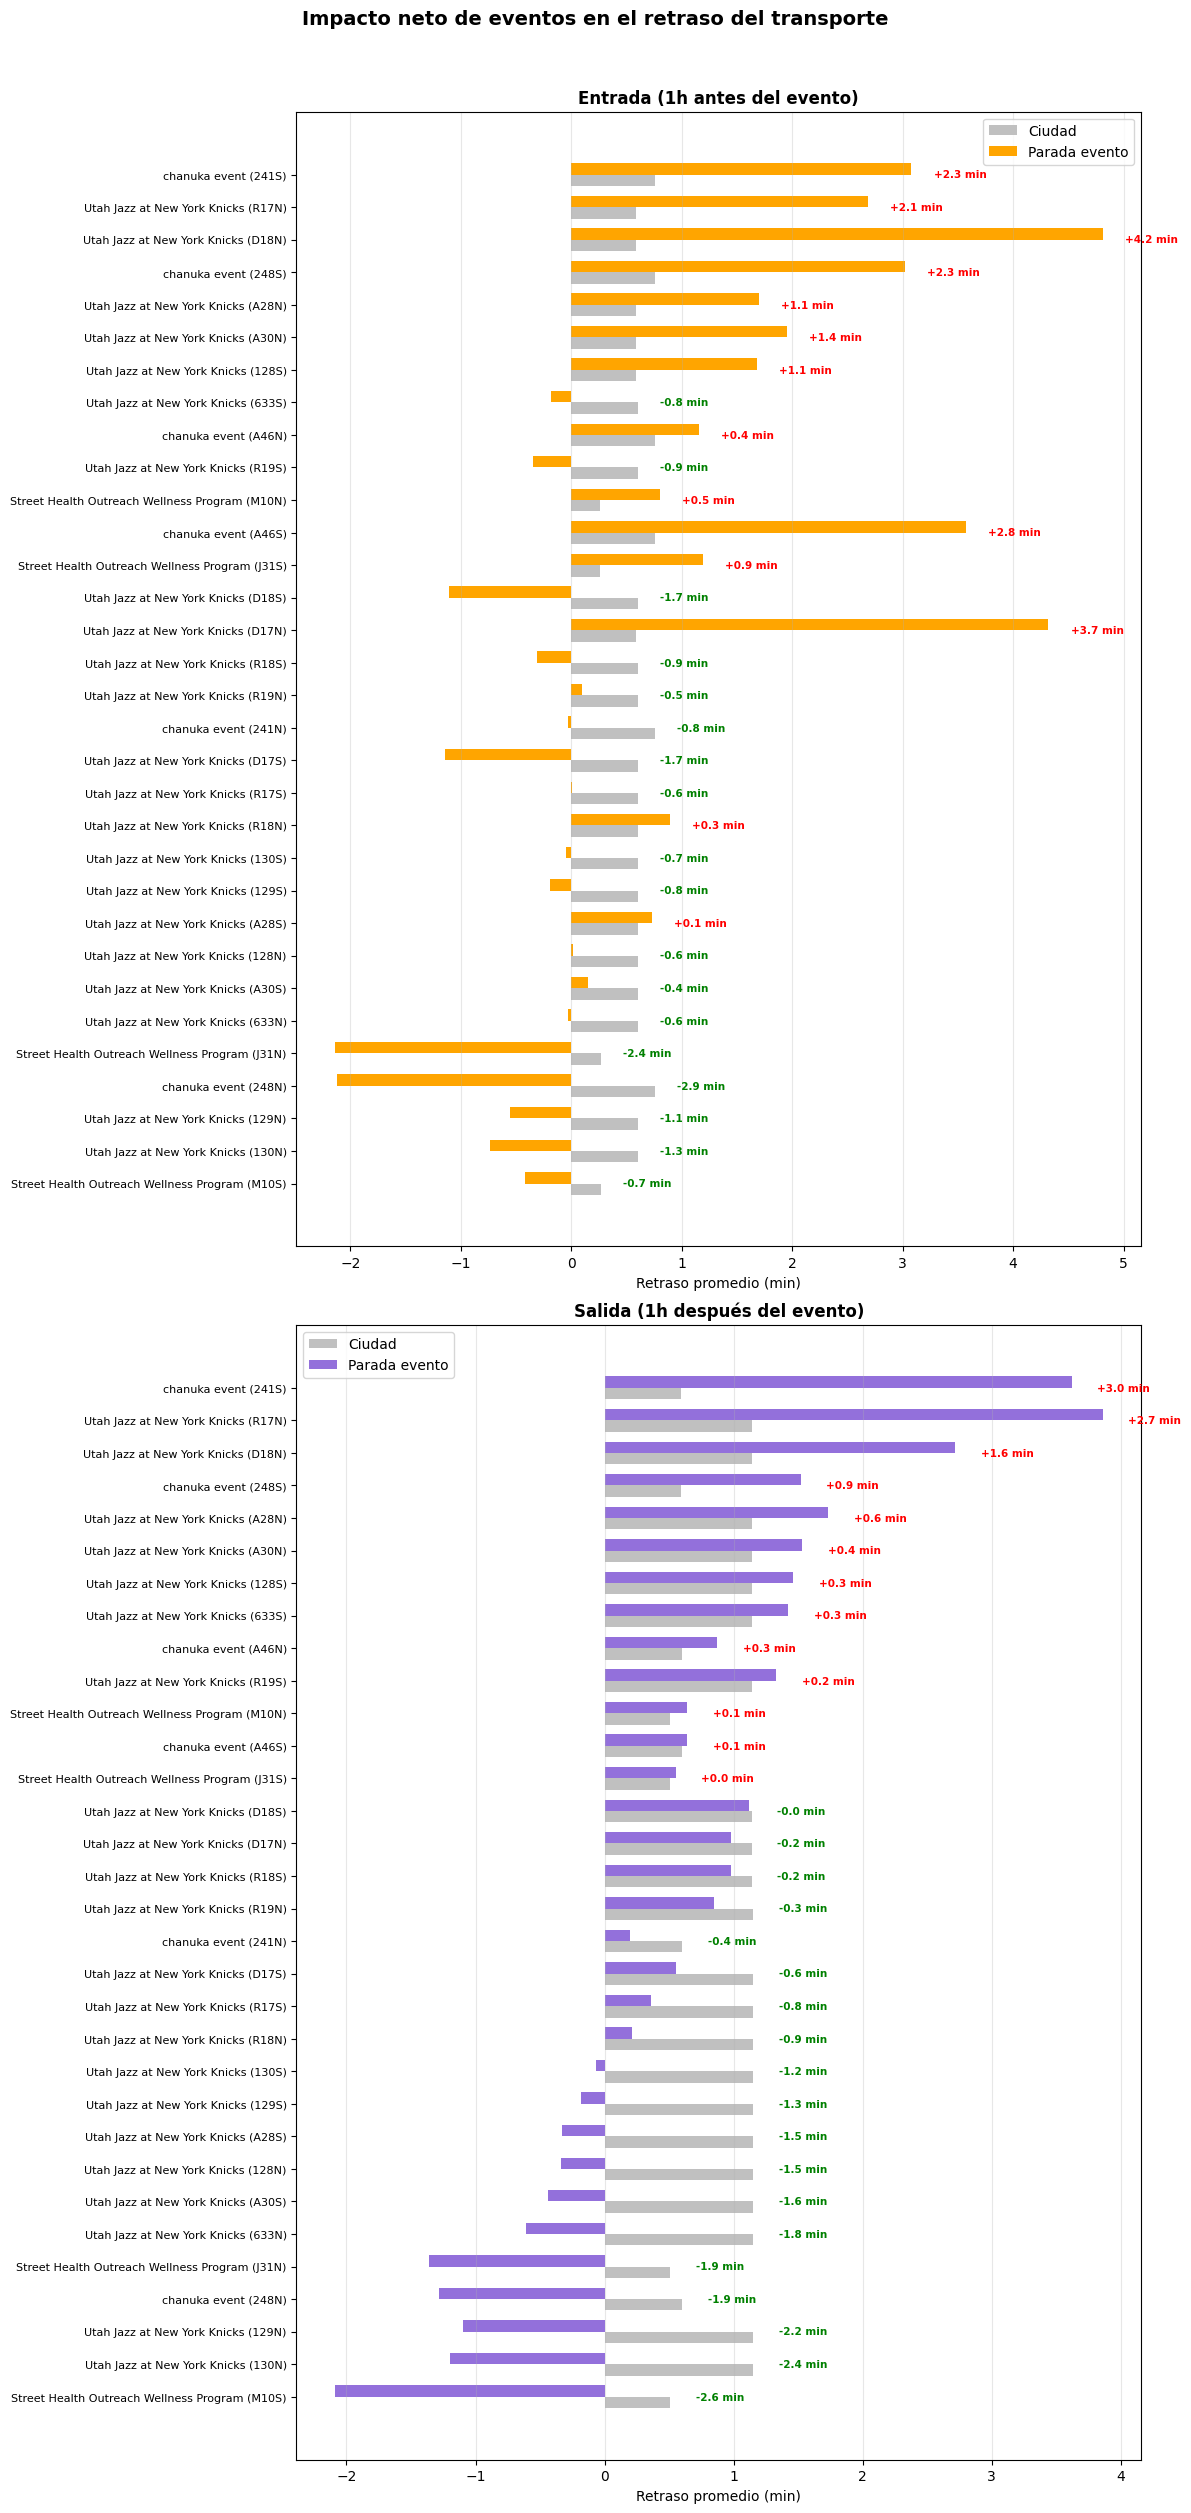

In [14]:
import matplotlib.pyplot as plt
import numpy as np

etiquetas = df_impacto['Evento'] + ' (' + df_impacto['Parada'].astype(str) + ')'
y = np.arange(len(etiquetas))
alto = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, max(10, len(etiquetas) * 0.8)))


ax1.barh(y + alto/2, df_impacto['Retraso Ciudad Entrada (Mins)'], alto, label='Ciudad', color='silver')
ax1.barh(y - alto/2, df_impacto['Retraso Parada Entrada (Mins)'], alto, label='Parada evento', color='orange')
for i, val in enumerate(df_impacto['Impacto NETO Entrada (Mins)']):
    xpos = max(df_impacto['Retraso Parada Entrada (Mins)'].iloc[i],
               df_impacto['Retraso Ciudad Entrada (Mins)'].iloc[i]) + 0.2
    color = 'red' if val > 0 else 'green'
    ax1.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color) #colocar el +-
ax1.set_title('Entrada (1h antes del evento)', fontweight='bold')
ax1.set_yticks(y)
ax1.set_yticklabels(etiquetas, fontsize=8)
ax1.set_xlabel('Retraso promedio (min)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()


ax2.barh(y + alto/2, df_impacto['Retraso Ciudad Salida (Mins)'], alto, label='Ciudad', color='silver')
ax2.barh(y - alto/2, df_impacto['Retraso Parada Salida (Mins)'], alto, label='Parada evento', color='mediumpurple')
for i, val in enumerate(df_impacto['Impacto NETO Salida (Mins)']):
    xpos = max(df_impacto['Retraso Parada Salida (Mins)'].iloc[i],
               df_impacto['Retraso Ciudad Salida (Mins)'].iloc[i]) + 0.2
    color = 'red' if val > 0 else 'green'
    ax2.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color)
ax2.set_title('Salida (1h después del evento)', fontweight='bold')
ax2.set_yticks(y)
ax2.set_yticklabels(etiquetas, fontsize=8)
ax2.set_xlabel('Retraso promedio (min)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

fig.suptitle('Impacto neto de eventos en el retraso del transporte', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()

In [15]:
resumen_final = []

ventana = pd.Timedelta(hours=2)
fin_dia = pd.Timedelta(hours=23, minutes=59)

for index, fila in df_e.iterrows():
    evento_nombre = fila['nombre_evento']
    stop = fila['stop_id']
    hora_inicio = pd.to_timedelta(fila['hora_inicio'])
    hora_salida = pd.to_timedelta(fila['hora_salida_estimada'])

    df_parada = df_s[df_s['stop_id'] == stop]

    antes   = df_parada[(df_parada['td_real'] >= hora_inicio - ventana*4) & (df_parada['td_real'] < hora_inicio - ventana)]
    entrada         = df_parada[(df_parada['td_real'] >= hora_inicio - ventana)   & (df_parada['td_real'] < hora_inicio)]
    durante     = df_parada[(df_parada['td_real'] >= hora_inicio) & (df_parada['td_real'] <= hora_salida)]
    salida       = df_parada[(df_parada['td_real'] > hora_salida)  & (df_parada['td_real'] <= hora_salida + ventana)]
    despues = df_parada[(df_parada['td_real'] > hora_salida + ventana)]#& (df_parada['td_real'] <= fin_dia)]

    resumen_final.append({
        'Evento':      evento_nombre,
        'Parada':      stop,
        'Antes':       round(antes['delay_minutes'].mean(), 2),
        'Entrada':     round(entrada['delay_minutes'].mean(), 2),
        'Durante':     round(durante['delay_minutes'].mean(), 2),
        'Salida':        round(salida['delay_minutes'].mean(), 2),
        'Después': round(despues['delay_minutes'].mean(), 2),
    })

df_resumen = pd.DataFrame(resumen_final)
#display(df_resumen)

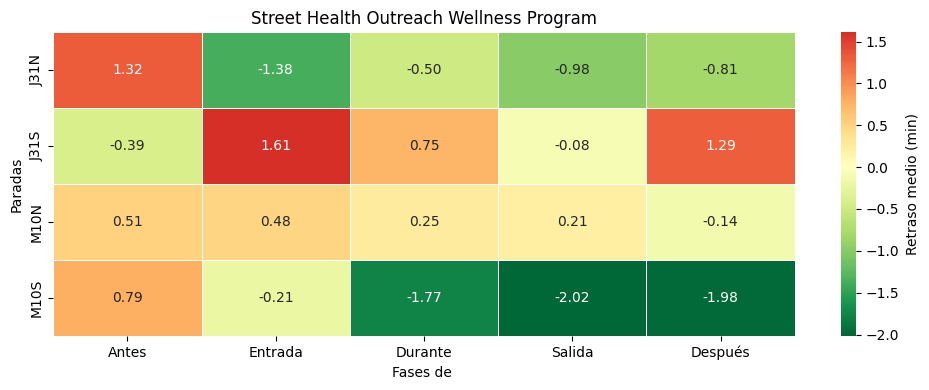

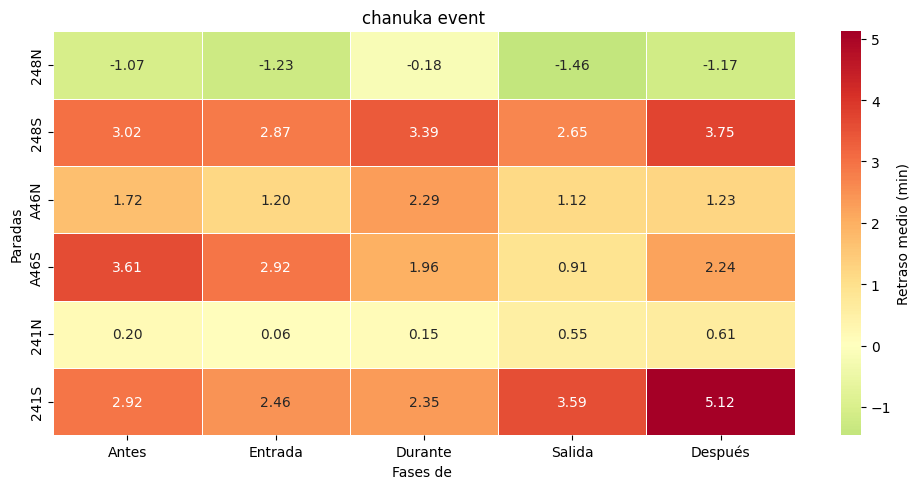

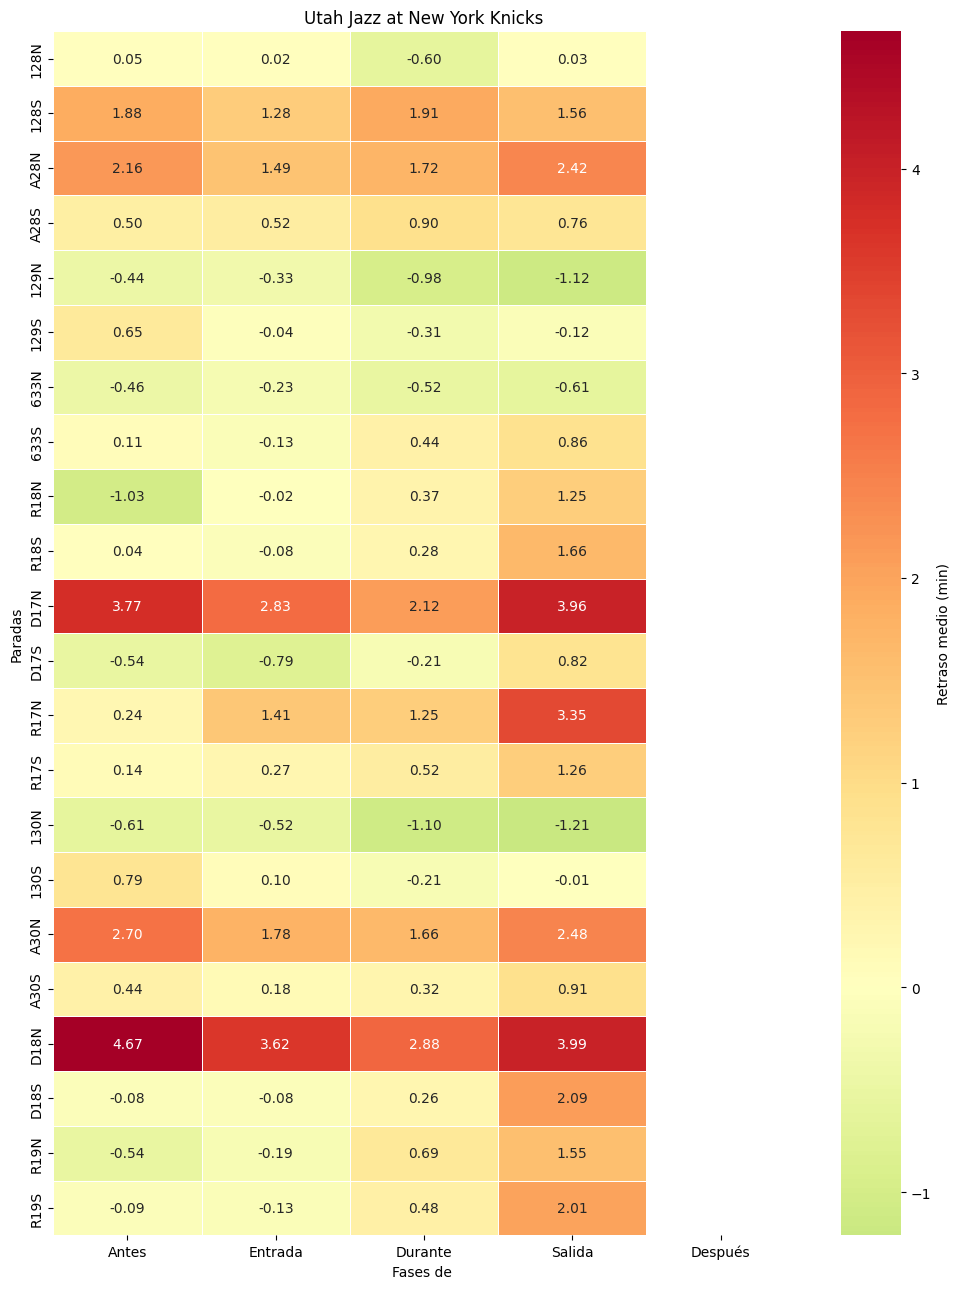

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


fases = ['Antes', 'Entrada', 'Durante', 'Salida', 'Después']

for evento_nombre in df_resumen['Evento'].unique():
    df_plot = df_resumen[df_resumen['Evento'] == evento_nombre].set_index('Parada')[fases]
    
    plt.figure(figsize=(10, len(df_plot) * 0.5 + 2))
    sns.heatmap(
        df_plot,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn_r',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Retraso medio (min)'}
    )
    plt.title(f'{evento_nombre}')
    plt.xlabel('Fases de ')
    plt.ylabel('Paradas')
    plt.tight_layout()
    plt.show()